In [1]:
%cd Chapter06

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'Chapter06'
C:\Users\revol\Chapter06


In [2]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


===========iteration:0===========
std=0.01:2.3025140987713484
Xavier:2.304973899082089
He:2.3991230562212547
===========iteration:100===========
std=0.01:2.302281047392082
Xavier:2.2664920204288164
He:1.4384209135916486
===========iteration:200===========
std=0.01:2.3006678443723847
Xavier:2.134569080695914
He:0.572488459470644
===========iteration:300===========
std=0.01:2.3015734913452977
Xavier:1.8896765086260119
He:0.6175056511366457
===========iteration:400===========
std=0.01:2.3031512391989306
Xavier:1.4436097961165661
He:0.5281545489907237
===========iteration:500===========
std=0.01:2.3023444931514963
Xavier:0.9387534279851399
He:0.4823862317266568
===========iteration:600===========
std=0.01:2.2977164708328384
Xavier:0.6268582992725322
He:0.34791843245147414
===========iteration:700===========
std=0.01:2.2986838077813347
Xavier:0.4928882494314002
He:0.2703833618493908
===========iteration:800===========
std=0.01:2.3033139564723615
Xavier:0.42782011055624347
He:0.2785876387218

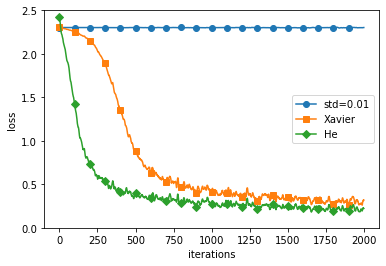

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()